# Walkthrough del uso de `difusion_lib` 

Este cuaderno explica **cómo usar la librería `difusion_lib`** para:
- Difundir masa en grafos
- Analizar componentes fuertemente conexas
- Ejecutar el proceso de *pelado*
- **Generar un Dashboard 3D interactivo combinado**
- Visualizar y exportar resultados

> **Requisito**: la librería `difusion_lib` debe ser accesible en el `PATH`.


## 1. Importaciones

Todo se importa directamente desde `difusion_lib`.


In [11]:
import networkx as nx
import pandas as pd

# Importación correcta de la librería
from difusion_lib import (
    MotorDifusion,
    AnalizadorPelado,
    VisualizadorPelado,
    ControladorPelado
)


## 2. Crear un grafo de ejemplo

Creamos un grafo dirigido con varias componentes fuertemente conexas
y asignamos masa inicial a cada nodo.


In [12]:
G = nx.DiGraph()

G.add_nodes_from(range(1, 7))
G.add_edges_from([
    (1, 2), (2, 3), (3, 1),
    (3, 4),
    (4, 5), (5, 4),
    (5, 6)
])

for n in G.nodes():
    G.nodes[n]['val'] = 1.0

G


## 3. Difusión de masa (`MotorDifusion`)

El motor redistribuye la masa de cada nodo entre sus vecinos.


In [13]:
motor = MotorDifusion(G, tasa_difusion=0.7)
motor.ejecutar(iteraciones=50)

nx.get_node_attributes(G, 'val')


{1: 0.00033162325039047503,
 2: 0.00041781911380153335,
 3: 0.0005264190965268956,
 4: 0.0015771326611200263,
 5: 0.0019823795441701437,
 6: 5.995164626333988}

## 4. Análisis de componentes (`AnalizadorPelado`)

Calculamos métricas por componente (masa, tamaño, impacto global).


In [14]:
metricas = AnalizadorPelado.obtener_metricas_cfc(
    G,
    version_pelado=0,
    total_nodos_original=len(G.nodes())
)

pd.DataFrame(metricas)


,capa_pelado,id_componente,nodos,tamano,es_trivial,masa_total,impacto_global
0,1,P1_C0,[6],1,True,5.995165,0.999194
1,1,P1_C1,"[4, 5]",2,False,0.003560,0.000593
2,1,P1_C2,"[1, 2, 3]",3,False,0.001276,0.000213


## 5. Visualización Estática y Dashboard Plotly (`VisualizadorPelado`)

Ahora el visualizador permite generar:
- **Imagen PNG** (Matplotlib)
- **Archivo GEXF** (Gephi)
- **Dashboard 3D Combinado** (Plotly con selector de capas)


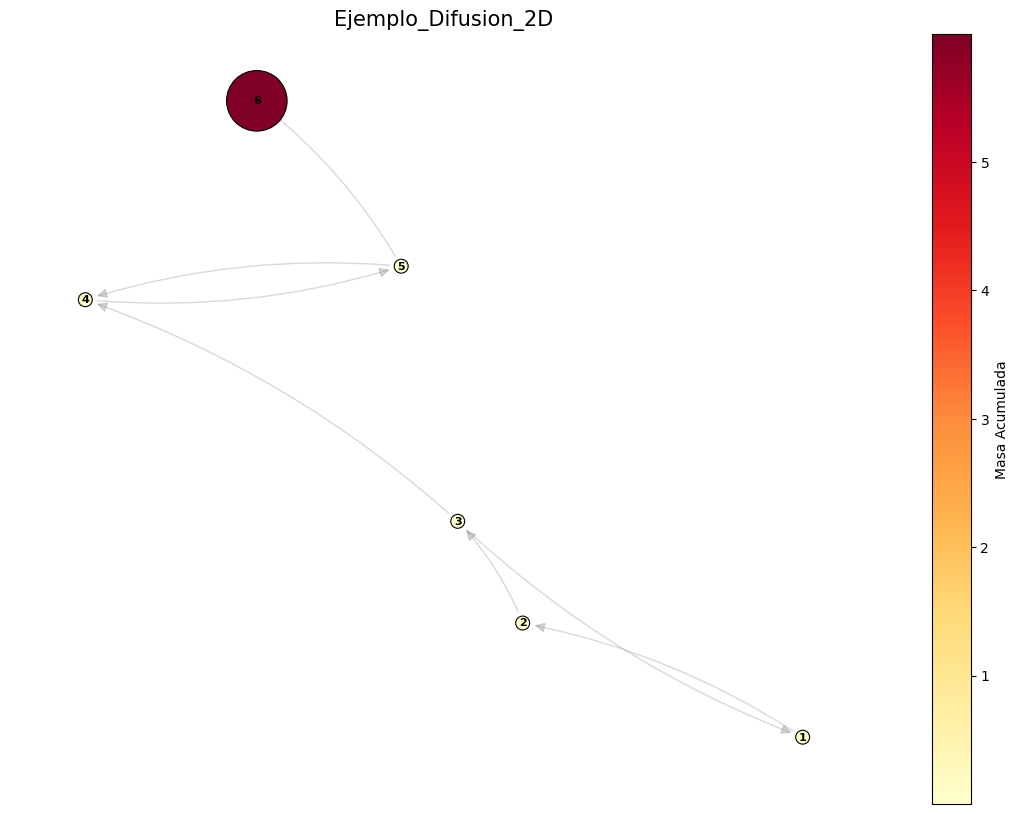

In [15]:
# Renderizado estático tradicional
VisualizadorPelado.renderizar(
    G,
    titulo="Ejemplo_Difusion_2D",
    ruta_base="salida_demo",
    exportar_gephi=True,
    mostrar_grafico=True
)

# NUEVO: Dashboard 3D Interactivo Combinado (Todas las capas en un solo gráfico)
VisualizadorPelado.renderizar_3d(
    G, 
    titulo="Dashboard_Difusion_3D", 
    ruta_base="salida_demo"
)


## 6. Proceso completo de pelado (`ControladorPelado`)

El controlador ahora genera automáticamente un único Dashboard interactivo que consolida todas las etapas del pelado.


In [16]:
controlador = ControladorPelado(G)

registro = controlador.ejecutar_estudio_pelado(
    num_pelados=3,
    iteraciones_por_pelado=50,
    umbral_masa=2.5,
    tasa_difusion=0.7,
    valor_inicio=1.0,
    exportar_resultados=True,
    carpeta_exportacion="salida_estudio"
)

pd.DataFrame(registro)


Iniciando Estudio: 6 nodos.
Pelado 1: Eliminando 1 componentes.
Pelado 2: Eliminando 1 componentes.
Pelado 3: Eliminando 1 componentes.


,capa_pelado,id_componente,nodos,tamano,es_trivial,masa_total,impacto_global,umbral_utilizado
0,1,P1_C0,[6],1,True,5.995165,0.999194,2.500000
1,2,P2_C0,"[4, 5]",2,False,4.998724,0.833121,2.083333
2,3,P3_C0,"[1, 2, 3]",3,False,3.000000,0.500000,1.250000


## 7. Salidas generadas

La carpeta de salida ahora incluye el dashboard consolidado:
- `imagenes_grafos/` → Visualizaciones 2D (PNG)
- **`dashboard_3d_interactivo.html`** → Un solo archivo con todas las vistas seleccionables
- `archivos_gephi/` → Grafos para Gephi (GEXF)
- `reportes_datos/` → CSVs analíticos
- `reporte_resumen_pelado.csv` → Historial del pelado


## 8. Simulación

El archivo `simulacion1.py` ejecuta el algoritmo de difusión y pelado sobre distintas topologías de red para comparar su comportamiento.

**Simulaciones incluidas:**
- Cascada jerárquica
- Red libre de escala (scale-free)
- Modelo estocástico por bloques (SBM)
- Red geométrica con masa inicial gaussiana
- Malla estocástica tipo NetLogo

Todas se ejecutan automáticamente y guardan sus resultados en carpetas separadas.
